# <font color=purple>Hotel Reservation Project - Eden Shalom 

## <font color=purple>Project Goals

##### The aim of the project is to help hoteliers better manage the cacellation policy and adjust the required resources according to the number of guests by predicting the probability of booking cancellation.

## <font color=purple> Data

The data set contains booking information for 119,390 observations: 
- City hotel - 79,330 observations 
- Resort hotel - 40,060 observations

Each observation represents a hotel booking. The dataset comprehend bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler , OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [24]:
df = pd.read_csv('/Users/eden/Documents/Hotel-Reservation/hotels.csv')

In [25]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [91]:
# number of empty cells in each column.
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [27]:
df.shape

(119390, 32)

### <font color=purple>Replace missing values

In [28]:
df1 = df.fillna({"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0})

In [29]:
# "Undefined" equal to "SC".
df1["meal"].replace("Undefined", "SC", inplace=True)

In [30]:
# Droped booking with no guests
no_guests = list(df1.loc[df1["adults"] + df1["children"] + df1["babies"]==0].index)
df1.drop(df1.index[no_guests], inplace=True)

In [31]:
df1.shape

(119210, 32)

## <font color=purple>Exploratory Data Analysis

### <font color=purple> Wich hotel has more reservations?

In [32]:
total_reservation = df1.shape[0]
total_rh = df1.loc[df1["hotel"] == "Resort Hotel"].shape[0]
total_ch = df1.loc[df1["hotel"] == "City Hotel"].shape[0]

#percent
rh_per = total_rh / total_reservation * 100
ch_per = total_ch / total_reservation * 100

print('\033[92m' f"Total bookings: {total_reservation:,}")
print('\033[92m' f"Resort hotel bookings: {total_rh:,} ({rh_per:.0f} %)")
print('\033[92m' f"City hotel bookings: {total_ch:,} ({ch_per:.0f} %)")

Total bookings: 119,210
Resort hotel bookings: 40,047 (34 %)
City hotel bookings: 79,163 (66 %)


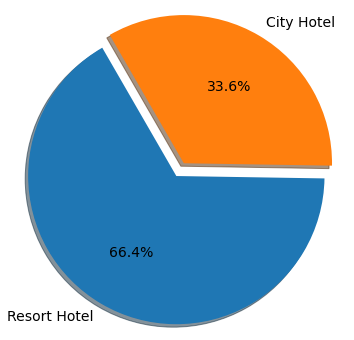

In [33]:
reservation_data = pd.DataFrame(df1["hotel"].value_counts())
reservation_data.rename(columns={"hotel": "Number of bookings"}, inplace=True)
total_reservation = df1.shape[0]
reservation_data["hotels in %"] = round(reservation_data["Number of bookings"] / total_reservation * 100, 2)
reservation_data["hotel"] = reservation_data.index

plt.rcParams['figure.figsize'] = 6,6
labels = df1["hotel"].unique().tolist()
sizes = round(reservation_data["Number of bookings"] / total_reservation * 100, 2)
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=120, textprops={'fontsize': 14})
ax1.axis('equal')

plt.show()

### <font color=purple> Repeated guest

In [34]:
df1['is_repeated_guest'].map({0:'Not repeated guest', 1:'Repeated guest'}).value_counts()

Not repeated guest    115455
Repeated guest          3755
Name: is_repeated_guest, dtype: int64

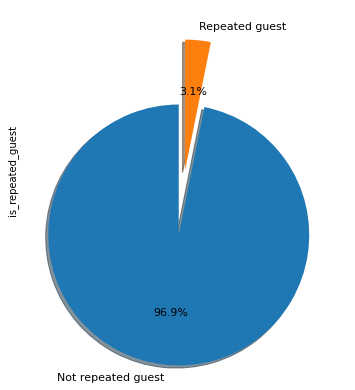

In [35]:
plt.rcParams['figure.figsize'] = 6,6
df1['is_repeated_guest'].map({0:'Not repeated guest', 1:'Repeated guest'}).value_counts().plot.pie(explode = (0.5,0), autopct='%1.1f%%',shadow=True, textprops={'fontsize': 11}, startangle=90)

##### <font color=blue>Low percentage of repeated guests.

### <font color=purple>Weekday or Weekend and Which are the most busy month?

In [36]:
df1['arrival_date_month'].replace({'January' : '1',
        'February' : '2',
        'March' : '3',
        'April' : '4',
        'May' : '5',
        'June' : '6',
        'July' : '7',
        'August' : '8',
        'September' : '9', 
        'October' : '10',
        'November' : '11',
        'December' : '12'}, inplace=True)

In [37]:
pd.options.mode.chained_assignment = None
def week_function(feature1, feature2, data_source):
    data_source['weekend_or_weekday'] = 0
    for i in range(0, len(data_source)):
        if feature2.iloc[i] == 0 and feature1.iloc[i] > 0:
            df1['weekend_or_weekday'].iloc[i] = 'stay_just_weekend'
        if feature2.iloc[i] > 0 and feature1.iloc[i] == 0:
            df1['weekend_or_weekday'].iloc[i] = 'stay_just_weekday'
        if feature2.iloc[i] > 0 and feature1.iloc[i] > 0:
            df1['weekend_or_weekday'].iloc[i] = 'stay_both_weekday_and_weekend'
        if feature2.iloc[i] == 0 and feature1.iloc[i] == 0:
            df1['weekend_or_weekday'].iloc[i] = 'undefined_data'

            
week_function(df1['stays_in_weekend_nights'],df1['stays_in_week_nights'], df1)

In [38]:
df2 = df1.copy()

Text(0, 0.5, 'Number of bookings')

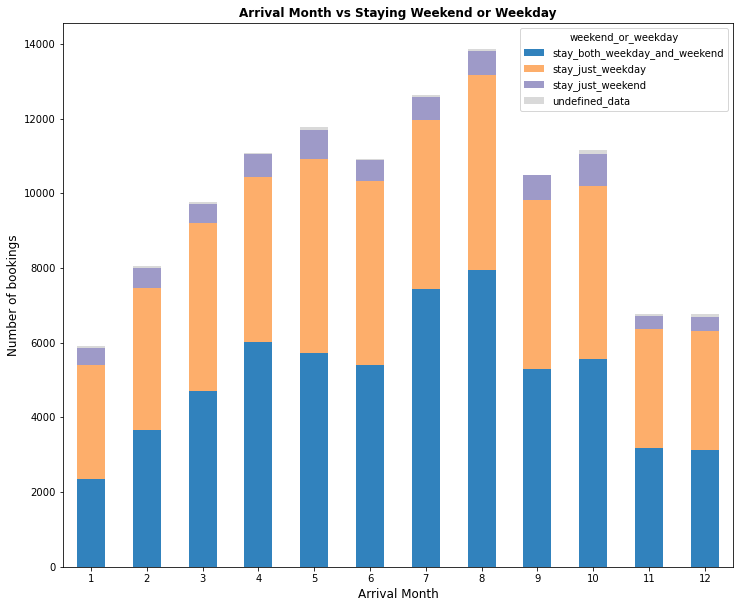

In [39]:
df2['arrival_date_month']= df1['arrival_date_month'].astype('int64')
group_data = df2.groupby([ 'arrival_date_month','weekend_or_weekday']).size().unstack(fill_value=0)
group_data.sort_values('arrival_date_month', ascending = True).plot(kind='bar',stacked=True, cmap='tab20c',figsize=(12,10))
plt.title('Arrival Month vs Staying Weekend or Weekday', weight='bold')
plt.xlabel('Arrival Month', fontsize=12)
plt.xticks(rotation=360)
plt.ylabel('Number of bookings', fontsize=12)

The graph shows that:

August is the busiest month and January is the most unoccupied month
Most bookings were made to stay only for weekdays or both weekdays and weekends. On the other, numbers of staying just the weekend category are quite low compared to other categories.

### <font color=purple>How long do people stay at the hotels?

In [40]:
#separate Resort and City hotel To know the acutal visitor numbers, only bookings that were not canceled are included.
rh = df1.loc[(df1["hotel"] == "Resort Hotel") & (df1["is_canceled"] == 0)]
ch = df1.loc[(df1["hotel"] == "City Hotel") & (df1["is_canceled"] == 0)]

In [41]:
# Create a DateFrame with the relevant data:
rh["total_nights"] = rh["stays_in_weekend_nights"] + rh["stays_in_week_nights"]
ch["total_nights"] = ch["stays_in_weekend_nights"] + ch["stays_in_week_nights"]

num_nights_res = list(rh["total_nights"].value_counts().index)
num_bookings_res = list(rh["total_nights"].value_counts())
rel_bookings_res = rh["total_nights"].value_counts() / sum(num_bookings_res) * 100 # convert to percent

num_nights_cty = list(ch["total_nights"].value_counts().index)
num_bookings_cty = list(ch["total_nights"].value_counts())
rel_bookings_cty = ch["total_nights"].value_counts() / sum(num_bookings_cty) * 100 # convert to percent

res_nights = pd.DataFrame({"hotel": "Resort hotel",
                           "num_nights": num_nights_res,
                           "rel_num_bookings": rel_bookings_res})

cty_nights = pd.DataFrame({"hotel": "City hotel",
                           "num_nights": num_nights_cty,
                           "rel_num_bookings": rel_bookings_cty})

nights_data = pd.concat([res_nights, cty_nights], ignore_index=True)
nights_data

,hotel,num_nights,rel_num_bookings
0,Resort hotel,1,22.743458
1,Resort hotel,2,15.514917
2,Resort hotel,7,15.328240
3,Resort hotel,3,13.233311
4,Resort hotel,4,11.480624
...,...,...,...
57,City hotel,18,0.002170
58,City hotel,20,0.002170
59,City hotel,34,0.002170
60,City hotel,21,0.002170


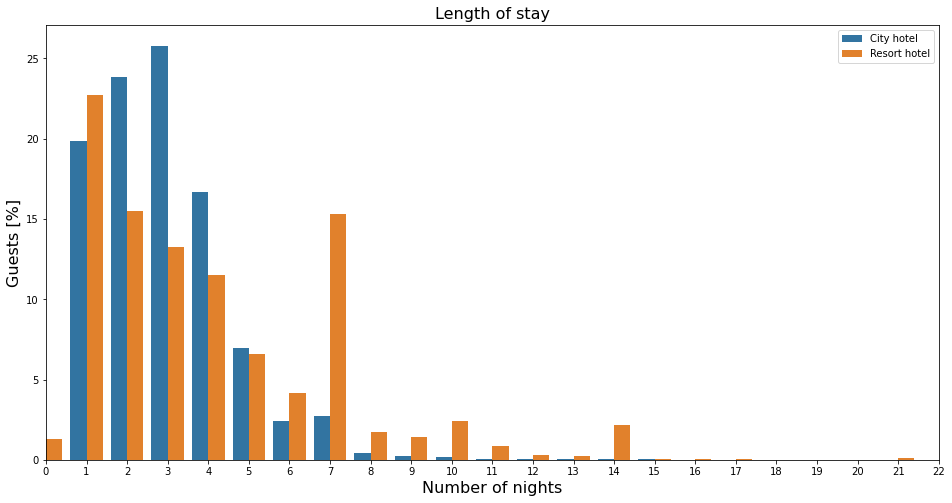

In [42]:
#show figure:
plt.figure(figsize=(16, 8))
sns.barplot(x = "num_nights", y = "rel_num_bookings", hue="hotel", data=nights_data,
            hue_order = ["City hotel", "Resort hotel"])
plt.title("Length of stay", fontsize=16)
plt.xlabel("Number of nights", fontsize=16)
plt.ylabel("Guests [%]", fontsize=16)
plt.legend(loc="upper right")
plt.xlim(0,22)
plt.show()

In [43]:
avg_nights_res = sum(list((res_nights["num_nights"] * (res_nights["rel_num_bookings"]/100)).values))
avg_nights_cty = sum(list((cty_nights["num_nights"] * (cty_nights["rel_num_bookings"]/100)).values))
print(f"On average, guests of the City hotel stay {avg_nights_cty:.2f} nights, and {cty_nights['num_nights'].max()} at maximum.")
print(f"On average, guests of the Resort hotel stay {avg_nights_res:.2f} nights, and {res_nights['num_nights'].max()} at maximum.")

On average, guests of the City hotel stay 2.92 nights, and 48 at maximum.
On average, guests of the Resort hotel stay 4.14 nights, and 69 at maximum.


### <font color=purple>Where do the guests come from?

In [44]:
# get number of acutal guests by country
country_data = pd.DataFrame(df1.loc[df1["is_canceled"] == 0]["country"].value_counts())[:10]
#country_data.index.name = "country"
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["Guests in %"]

PRT    33.99
GBR    15.67
FRA    13.72
ESP    10.34
DEU     9.83
IRL     4.12
ITA     3.93
BEL     3.03
NLD     2.78
USA     2.58
Name: Guests in %, dtype: float64

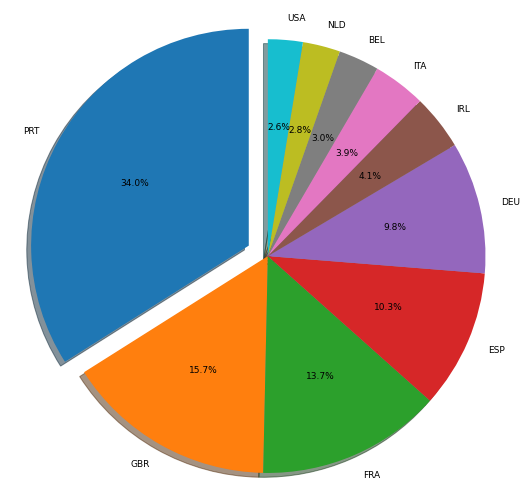

In [45]:
# get number of acutal guests by country
country_data = pd.DataFrame(df1.loc[df1["is_canceled"] == 0]["country"].value_counts())[:10]
#country_data.index.name = "country"
country_data.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
country_data["country"] = country_data.index


plt.rcParams['figure.figsize'] = 9,9
labels = country_data.index
sizes = total_guests = country_data["Number of Guests"]
explode = (0.1,0,0,0,0,0,0,0,0,0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 9})
ax1.axis('equal')

plt.show()


## <font color=purple>cancellations

### How many bookings were canceled?

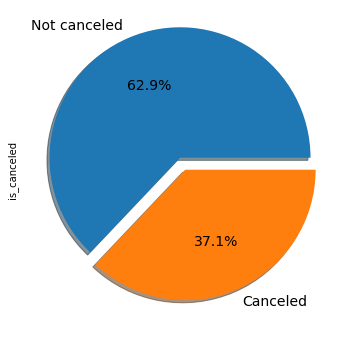

In [46]:
plt.rcParams['figure.figsize'] = 6,6
df1["is_canceled"].map({0:'Not canceled', 1:'Canceled'}).value_counts().plot.pie(explode = (0.1,0), autopct='%1.1f%%',shadow=True, textprops={'fontsize': 14})

In [47]:
# absolute cancelations:
total_cancelations = df1["is_canceled"].sum()
rh_cancelations = df1.loc[df1["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = df1.loc[df1["hotel"] == "City Hotel"]["is_canceled"].sum()

# as percent:
rel_cancel = total_cancelations / df1.shape[0] * 100
rh_rel_cancel = rh_cancelations / df1.loc[df1["hotel"] == "Resort Hotel"].shape[0] * 100
ch_rel_cancel = ch_cancelations / df1.loc[df1["hotel"] == "City Hotel"].shape[0] * 100

print(f"Total bookings canceled: {total_cancelations:,} ({rel_cancel:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancelations:,} ({rh_rel_cancel:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancelations:,} ({ch_rel_cancel:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


### <font color=purple>Cancelation rates in City hotel and Resort hotel

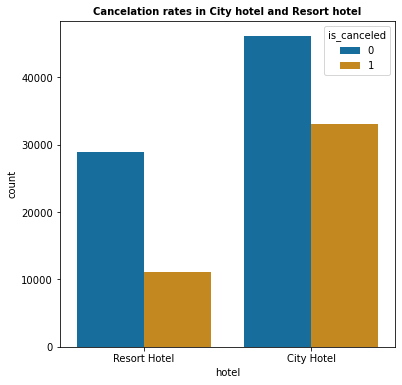

In [48]:
plt.figure(figsize=(6, 6))

sns.countplot(x=df1["hotel"],hue=df1["is_canceled"], data=df1,palette='colorblind')
plt.title("Cancelation rates in City hotel and Resort hotel",fontweight="bold", size=10)
plt.show()

Most bookings were in city hotel
Cancelations in Resort hotel is less compared to city hotel

### <font color=purple>Monthly Cancellations and Customers by Hotel Types

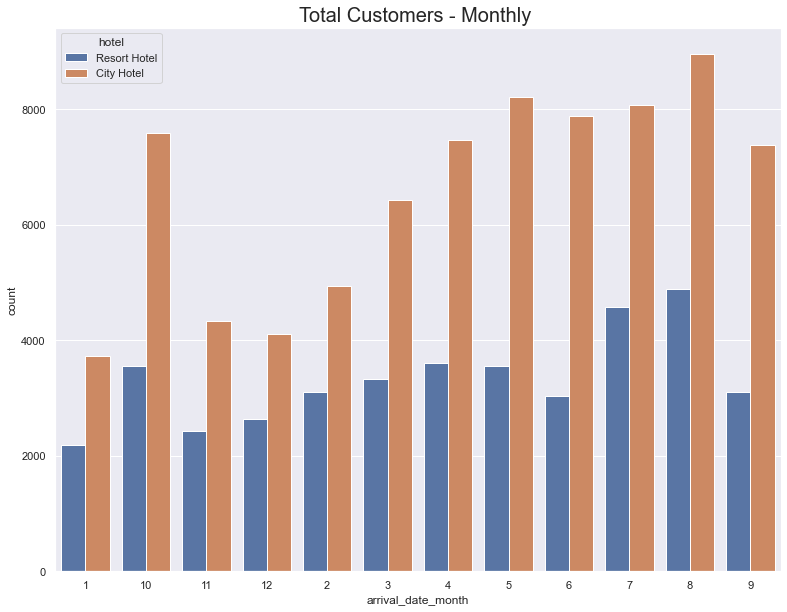

In [49]:
plt.figure(figsize =(13,10))
sns.set(style="darkgrid")
plt.title("Total Customers - Monthly ", fontdict={'fontsize': 20})
ax = sns.countplot(x = df1["arrival_date_month"], hue = df1['hotel'], data = df1)

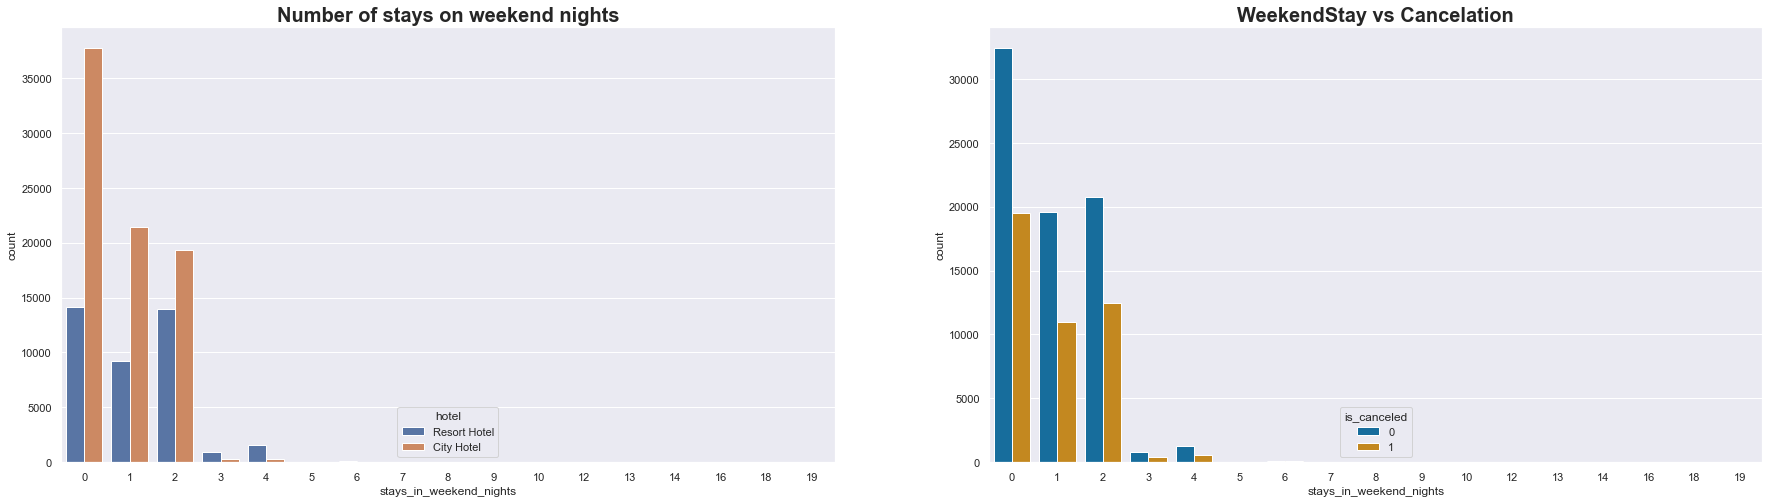

In [50]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
sns.countplot(x=df1['stays_in_weekend_nights'],hue=df1["hotel"], data=df1)
plt.title("Number of stays on weekend nights",fontweight="bold", size=20)
plt.subplot(1, 2, 2)
sns.countplot(data = df1, x=df1['stays_in_weekend_nights'], hue=df1["is_canceled"], palette='colorblind')
plt.title('WeekendStay vs Cancelation',fontweight="bold", size=20)
plt.subplots_adjust(right=1.7)

plt.show()

In the first graph we can see that most of the weekend nights were booked in City Hotel
Second plot shows most of weekend nights which were booked were not canceled

### <font color=purple>Boxplot Distribution of Nights Spent at Hotels by Market Segment and Hotel Type

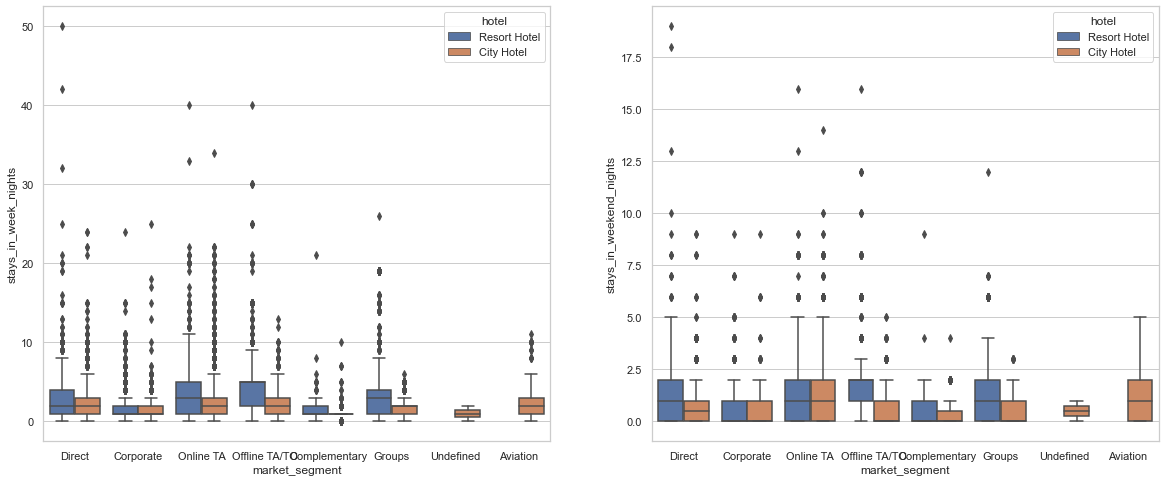

In [51]:
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")
plt.subplot(1, 2, 1)
#plt.figure(figsize = (15,10))
sns.boxplot(x = df1["market_segment"], y = df1["stays_in_week_nights"], data = df1, hue = df1["hotel"]);
#plt.figure(figsize=(15,10))
plt.subplot(1, 2, 2)
sns.boxplot(x = df1["market_segment"], y = df1["stays_in_weekend_nights"], data = df1, hue = df1["hotel"]);

### <font color=purple>Countplot Distribution of Market Segments

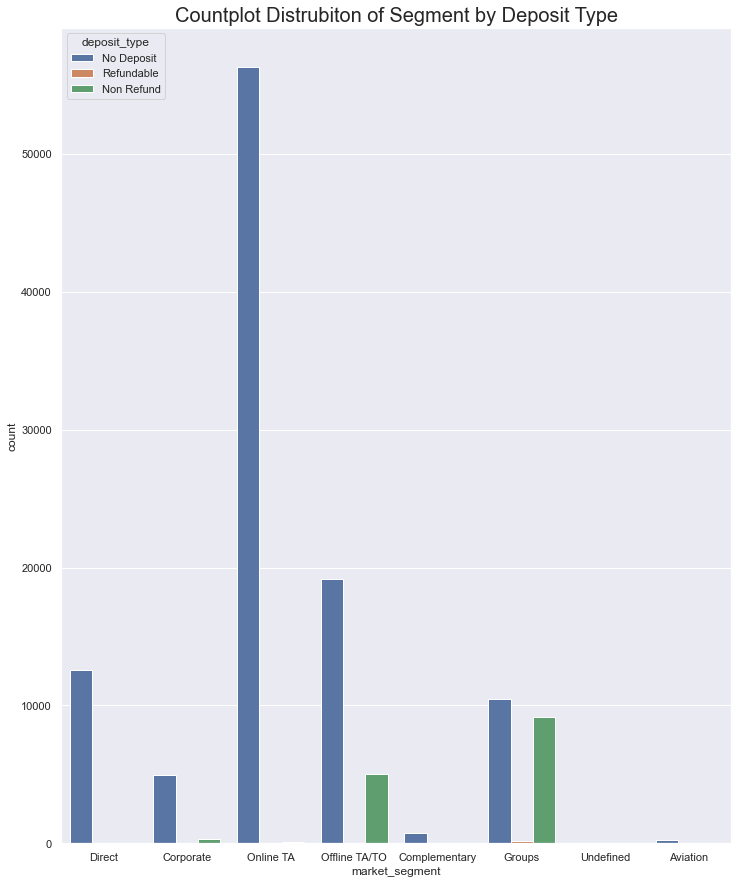

In [52]:
plt.figure(figsize = (12,15))
sns.set(style = "darkgrid")
plt.title("Countplot Distrubiton of Segment by Deposit Type", fontdict = {'fontsize':20})
ax = sns.countplot(x = df1["market_segment"], hue = df1['deposit_type'], data = df1)

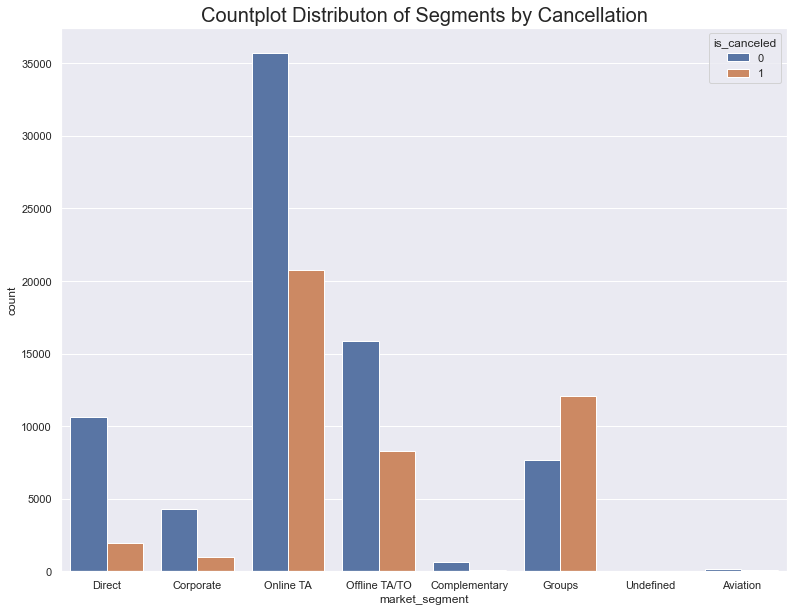

In [53]:
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Countplot Distributon of Segments by Cancellation", fontdict = {'fontsize':20})
ax = sns.countplot(x = df1["market_segment"], hue = df1['is_canceled'], data = df1)

### <font color=purple>Missing Data & Correlation Matrix

In [54]:
df3 = df.copy()

In [56]:
def per_missing_values(x,y):
    per = y.isnull().sum()/len(x) * 100
    return per

print('Missing value ratios:\nCompany: {}\nAgent: {}\nCountry: {}'.format(per_missing_values(df3, df3['company']),
                                                                          per_missing_values(df3, df3['agent']),
                                                                          per_missing_values(df3, df3['country'])))

Missing value ratios:
Company: 94.30689337465449
Agent: 13.686238378423655
Country: 0.40874445095904177


In [57]:
data = df.copy()

In [58]:
data["agent"].value_counts().count()

333

In [59]:
# drop company column
data = data.drop(['company'], axis = 1)

In [60]:
# missing values in children column
data['children'] = data['children'].fillna(0)

### <font color=purple>Handling Features

We should check the features to create some more meaningful variables and reduce the number of features if it is possible.

In [62]:
# I wanted to label them manually. I will do the rest with get.dummies or label_encoder.
data['hotel'] = data['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

data['arrival_date_month'] = data['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})

In [63]:
def family(data):
    if ((data['adults'] > 0) & (data['children'] > 0)):
        val = 1
    elif ((data['adults'] > 0) & (data['babies'] > 0)):
        val = 1
    else:
        val = 0
    return val

def deposit(data):
    if ((data['deposit_type'] == 'No Deposit') | (data['deposit_type'] == 'Refundable')):
        return 0
    else:
        return 1

In [64]:
def feature(data):
    data["is_family"] = data.apply(family, axis = 1)
    data["total_customer"] = data["adults"] + data["children"] + data["babies"]
    data["deposit_given"] = data.apply(deposit, axis=1)
    data["total_nights"] = data["stays_in_weekend_nights"]+ data["stays_in_week_nights"]
    return data

data = feature(data)

In [65]:
# Information of these columns is also inside of new features, so it is better to drop them.
# I did not drop stays_nights features, I can't decide which feature is more important there.
data = data.drop(columns = ['adults', 'babies', 'children', 'deposit_type', 'reservation_status_date'])

After correlation we will decide what to do about country, agent and total_nights.

## <font color=purple>Correlation

In [66]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'is_family', 'total_customer', 'deposit_given',
       'total_nights'],
      dtype='object')

In [67]:
# Lets copy data to check the correlation between variables. 
cor_data = data.copy()

In [68]:
le = LabelEncoder()

In [69]:
# This data will not be used while predicting cancellation. This is just for checking correlation.
cor_data['meal'] = le.fit_transform(cor_data['meal'])
cor_data['distribution_channel'] = le.fit_transform(cor_data['distribution_channel'])
cor_data['reserved_room_type'] = le.fit_transform(cor_data['reserved_room_type'])
cor_data['assigned_room_type'] = le.fit_transform(cor_data['assigned_room_type'])
cor_data['agent'] = le.fit_transform(cor_data['agent'])
cor_data['customer_type'] = le.fit_transform(cor_data['customer_type'])
cor_data['reservation_status'] = le.fit_transform(cor_data['reservation_status'])
cor_data['market_segment'] = le.fit_transform(cor_data['market_segment'])

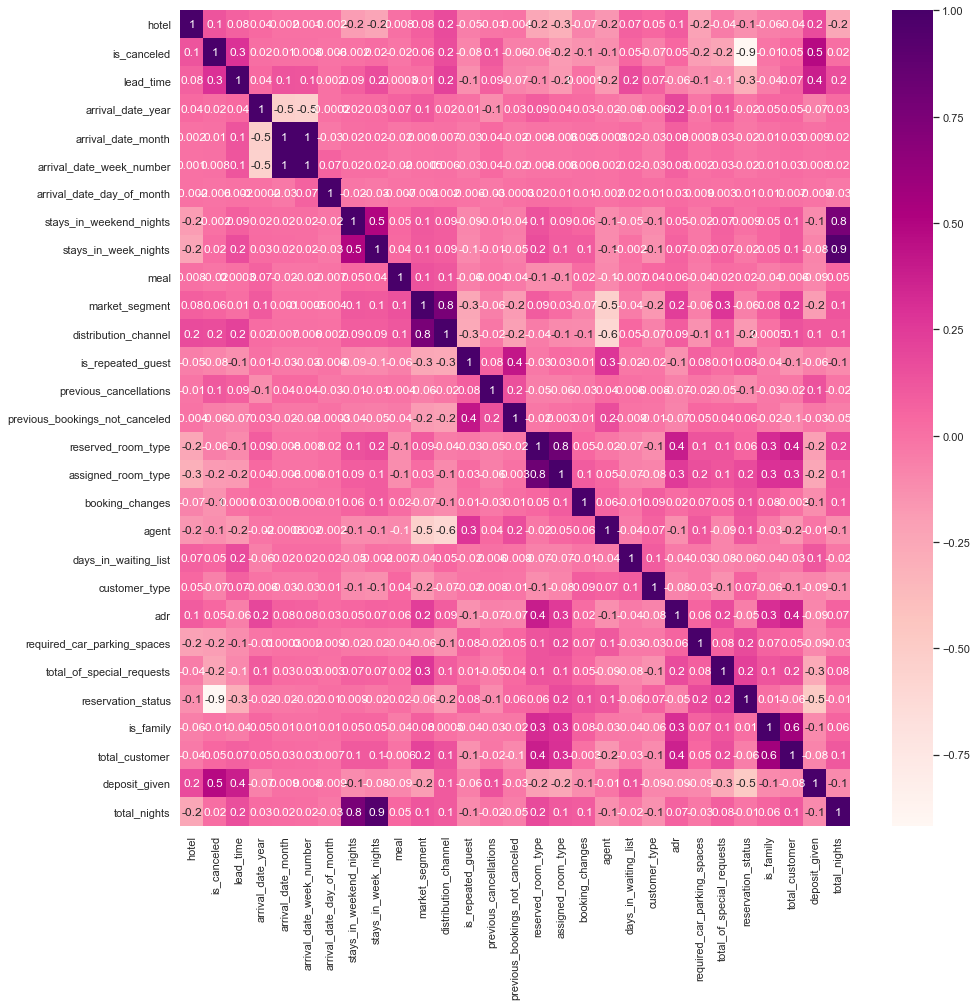

In [70]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cor_data.corr(), ax=ax, annot = True, cmap= 'RdPu', fmt='.1g')
plt.show()

In [71]:
cor_data.corr()["is_canceled"].sort_values()

reservation_status               -0.917196
total_of_special_requests        -0.234658
required_car_parking_spaces      -0.195498
assigned_room_type               -0.176028
booking_changes                  -0.144381
agent                            -0.127883
is_repeated_guest                -0.084793
customer_type                    -0.068140
reserved_room_type               -0.061282
previous_bookings_not_canceled   -0.057358
meal                             -0.017678
is_family                        -0.013010
arrival_date_day_of_month        -0.006130
stays_in_weekend_nights          -0.001791
arrival_date_week_number          0.008148
arrival_date_month                0.011022
arrival_date_year                 0.016660
total_nights                      0.017779
stays_in_week_nights              0.024765
total_customer                    0.046522
adr                               0.047557
days_in_waiting_list              0.054186
market_segment                    0.059338
previous_ca

In [72]:
# It is highly correlated to total_nights and also there is no much difference impact, so I will not use total_nights.
# Week nights have higher impact.
"""
Actually, I tried some models by using different features as (only total_nights | weekend_nights and week_nights | only week_nights ...) 
and the models using only week nights seems to have a bit higher accuracy score. 
"""

cor_data.corr()['stays_in_week_nights']

hotel                            -0.234020
is_canceled                       0.024765
lead_time                         0.165799
arrival_date_year                 0.030883
arrival_date_month                0.019212
arrival_date_week_number          0.015558
arrival_date_day_of_month        -0.028174
stays_in_weekend_nights           0.498969
stays_in_week_nights              1.000000
meal                              0.036742
market_segment                    0.108569
distribution_channel              0.087185
is_repeated_guest                -0.097245
previous_cancellations           -0.013992
previous_bookings_not_canceled   -0.048743
reserved_room_type                0.168616
assigned_room_type                0.100795
booking_changes                   0.096209
agent                            -0.110354
days_in_waiting_list             -0.002020
customer_type                    -0.127223
adr                               0.065237
required_car_parking_spaces      -0.024859
total_of_sp

In [73]:
cor_data = cor_data.drop(columns = ['total_nights', 'arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'agent'], axis = 1)

In [74]:
#Lets delete the NA rows of country column
indices = cor_data.loc[pd.isna(cor_data["country"]), :].index 
cor_data = cor_data.drop(cor_data.index[indices])   
cor_data.isnull().sum()

#There is no missing value in the data

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_day_of_month         0
stays_in_week_nights              0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
is_family                         0
total_customer                    0
deposit_given                     0
dtype: int64

Since we have decided what to do with features and missing values, we can work on first data.

In [75]:
indices = data.loc[pd.isna(data["country"]), :].index 
data = data.drop(data.index[indices])   
data = data.drop(columns = ['arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'agent'], axis = 1)

In [76]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_day_of_month', 'stays_in_week_nights', 'meal', 'country',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'is_family', 'total_customer', 'deposit_given',
       'total_nights'],
      dtype='object')

In [77]:
data.shape

(118902, 26)

In [78]:
# I keep data in case of any changes on features, missing values etc.
df4 = data.copy()

In [79]:
#one-hot-encoding
df4 = pd.get_dummies(data = df4, columns = ['meal', 'market_segment', 'distribution_channel',
                                            'reserved_room_type', 'assigned_room_type', 'customer_type', 'reservation_status'])

In [80]:
df4.shape

(118902, 66)

In [81]:
df4['country'] = le.fit_transform(df4['country']) 
# There are more than 300 classes, so I wanted to use label encoder on this feature.

### <font color=purple>Decision Tree Model (reservation_status included)

In [82]:
y = df4["is_canceled"]
X = df4.drop(["is_canceled"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [83]:
cart = DecisionTreeClassifier(max_depth = 12)

In [84]:
cart_model = cart.fit(X_train, y_train)

In [85]:
y_pred = cart_model.predict(X_test)

In [86]:
print('Decision Tree Model')

print('Accuracy Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred), roc_auc_score(y_test,y_pred)))

Decision Tree Model
Accuracy Score: 1.0

Confusion Matrix:
 [[22353     0]
 [    0 13318]]

AUC Score: 1.0


## <font color=purple>Final Arrangements Before Comparing the Models

In [87]:
df5 = df4.drop(columns = ['reservation_status_Canceled', 'reservation_status_Check-Out', 'reservation_status_No-Show'], axis = 1)

In [88]:
y = df5["is_canceled"]
X = df5.drop(["is_canceled"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [89]:
# We can use the functions to apply the models and roc curves to save space.
def model(algorithm, X_train, X_test, y_train, y_test):
    alg = algorithm
    alg_model = alg.fit(X_train, y_train)
    global y_prob, y_pred
    y_prob = alg.predict_proba(X_test)[:,1]
    y_pred = alg_model.predict(X_test)

    print('Accuracy Score: {}\n\nConfusion Matrix:\n {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred)))

## <font color=purple>Model and ROC Curve Comparison

Accuracy Score: 0.8043508732583892

Confusion Matrix:
 [[20495  1858]
 [ 5121  8197]]
Accuracy Score: 0.586246530795324

Confusion Matrix:
 [[ 9604 12749]
 [ 2010 11308]]
Accuracy Score: 0.84614953323428

Confusion Matrix:
 [[20366  1987]
 [ 3501  9817]]
Accuracy Score: 0.8841636062908245

Confusion Matrix:
 [[20965  1388]
 [ 2744 10574]]


Text(0.5, 0, 'False Positive Rate')

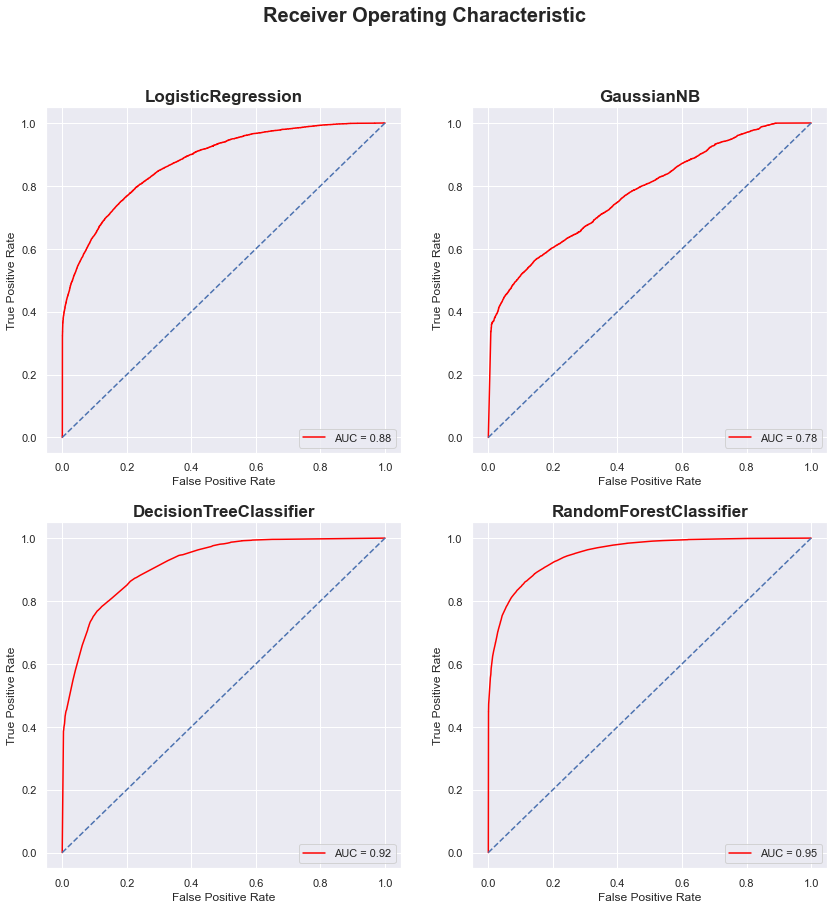

In [90]:

fig, axs = plt.subplots(2, 2, figsize=(14,14))
fig.suptitle('Receiver Operating Characteristic',fontweight="bold", size=20)

model(LogisticRegression(solver = "liblinear"), X_train, X_test, y_train, y_test)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)  
#ax1.figure(figsize = (10,10))
axs[0, 0].set_title('LogisticRegression',fontweight="bold", size=17)
axs[0, 0].plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
axs[0, 0].legend(loc = 'lower right')
axs[0, 0].plot([0, 1], [0, 1], linestyle = '--')
axs[0, 0].set_ylabel('True Positive Rate')
axs[0, 0].set_xlabel('False Positive Rate')

model(GaussianNB(), X_train, X_test, y_train, y_test)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
roc_auc1 = auc(false_positive_rate, true_positive_rate)
#ax2.figure(figsize = (10,10))
axs[0, 1].set_title('GaussianNB',fontweight="bold", size=17)
axs[0, 1].plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc1)
axs[0, 1].legend(loc = 'lower right')
axs[0, 1].plot([0, 1], [0, 1], linestyle = '--')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].set_xlabel('False Positive Rate')

model(DecisionTreeClassifier(max_depth = 12), X_train, X_test, y_train, y_test)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
roc_auc3 = auc(false_positive_rate, true_positive_rate)
#ax2.figure(figsize = (10,10))
axs[1, 0].set_title('DecisionTreeClassifier',fontweight="bold", size=17)
axs[1, 0].plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc3)
axs[1, 0].legend(loc = 'lower right')
axs[1, 0].plot([0, 1], [0, 1], linestyle = '--')
axs[1, 0].set_ylabel('True Positive Rate')
axs[1, 0].set_xlabel('False Positive Rate')

model(RandomForestClassifier(), X_train, X_test, y_train, y_test)
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
roc_auc4 = auc(false_positive_rate, true_positive_rate)
#ax2.figure(figsize = (10,10))
axs[1, 1].set_title('RandomForestClassifier',fontweight="bold", size=17)
axs[1, 1].plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc4)
axs[1, 1].legend(loc = 'lower right')
axs[1, 1].plot([0, 1], [0, 1], linestyle = '--')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].set_xlabel('False Positive Rate')

As we can see, the best algorithm is random forest for this data set.
0 values are uncalculated ones.